# Bivariate Truncated Parabola: Data Generation and Gradient-Based Fitting

For dimension $N$, use

$$
\hat p(t)=\left[-\tau-\frac12(t-\mu)^\top\Sigma^{-1}(t-\mu)\right]_+,
$$

with

$$
\tau=-\left(\frac{\Gamma\!\left(\frac{N}{2}+2\right)}{\sqrt{\det(2\pi\Sigma)}}\right)^{\frac{2}{N+2}}.
$$

For one sample $t_0$, the attached loss is

$$
\ell(t_0;\mu,\Sigma)
=\left(\frac12+\frac{N+2}{N+4}\tau\right)_+
+\frac12(t_0-\mu)^\top\Sigma^{-1}(t_0-\mu).
$$

This notebook demonstrates the **bivariate** case ($N=2$): generate synthetic data, then fit $(\mu,\Sigma)$ by gradient-based optimization.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

np.random.seed(7)
torch.manual_seed(7)


In [2]:
def tau_from_cov(cov):
    # cov: (2, 2) SPD numpy array
    n = cov.shape[0]
    det_term = np.linalg.det(2.0 * np.pi * cov)
    numerator = math.gamma(n / 2.0 + 2.0)
    return - (numerator / np.sqrt(det_term)) ** (2.0 / (n + 2.0))


def density_bivariate_trunc_parabola(x, mu, cov):
    # x: (..., 2)
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    maha = np.einsum('...i,ij,...j->...', delta, inv_cov, delta)
    tau = tau_from_cov(cov)
    return np.maximum(-tau - 0.5 * maha, 0.0)


def support_radius_for_ball_envelope(cov):
    # Support obeys: 0.5 * delta^T inv_cov delta <= -tau.
    # Using lambda_min(inv_cov) gives a conservative Euclidean ball envelope.
    tau = tau_from_cov(cov)
    inv_cov = np.linalg.inv(cov)
    lam_min = np.linalg.eigvalsh(inv_cov).min()
    return np.sqrt(2.0 * (-tau) / lam_min)


def sample_bivariate_trunc_parabola(mu, cov, n, batch_size=8192):
    tau = tau_from_cov(cov)
    fmax = -tau
    r = support_radius_for_ball_envelope(cov)

    out = []
    while len(out) < n:
        x = np.random.uniform(mu - r, mu + r, size=(batch_size, 2))
        y = np.random.uniform(0.0, fmax, size=batch_size)
        fx = density_bivariate_trunc_parabola(x, mu, cov)
        accepted = x[y <= fx]
        out.extend(accepted.tolist())

    return np.array(out[:n], dtype=np.float64)


In [3]:
# Ground-truth parameters
mu_true = np.array([1.2, -0.7], dtype=np.float64)
Sigma_true = np.array([[1.1, 0.45], [0.45, 0.8]], dtype=np.float64)
n_samples = 5000

samples = sample_bivariate_trunc_parabola(mu_true, Sigma_true, n_samples)

print(f"Generated {len(samples)} samples")
print("sample mean:", samples.mean(axis=0))
print("sample covariance:", np.cov(samples.T))


Generated 5000 samples
sample mean: [ 1.20328669 -0.70298289]
sample covariance: [[0.23802161 0.09741412]
 [0.09741412 0.16608755]]


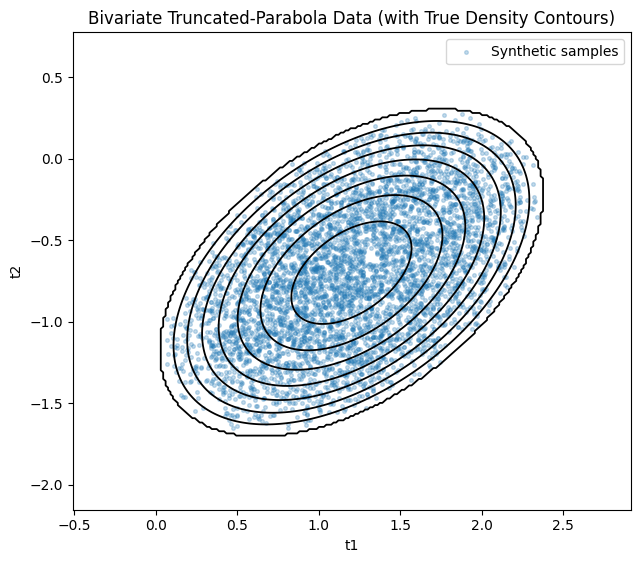

In [4]:
# Visualize synthetic data and true density contours
x_min, x_max = samples[:, 0].min() - 0.5, samples[:, 0].max() + 0.5
y_min, y_max = samples[:, 1].min() - 0.5, samples[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 220), np.linspace(y_min, y_max, 220))
grid = np.stack([xx, yy], axis=-1)
zz_true = density_bivariate_trunc_parabola(grid, mu_true, Sigma_true)

plt.figure(figsize=(7.2, 6.2))
plt.scatter(samples[:, 0], samples[:, 1], s=7, alpha=0.25, color='tab:blue', label='Synthetic samples')
plt.contour(xx, yy, zz_true, levels=9, colors='black', linewidths=1.3)
plt.title('Bivariate Truncated-Parabola Data (with True Density Contours)')
plt.xlabel('t1')
plt.ylabel('t2')
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()


In [5]:
def tau_from_cov_torch(cov):
    n = cov.shape[0]
    det_term = torch.det(2.0 * torch.pi * cov)
    numerator = math.gamma(n / 2.0 + 2.0)
    return - (numerator / torch.sqrt(det_term)) ** (2.0 / (n + 2.0))


def batch_loss(t, mu, cov):
    # t: (m, 2)
    n = t.shape[1]
    tau = tau_from_cov_torch(cov)
    inv_cov = torch.inverse(cov)
    delta = t - mu
    maha = torch.einsum('bi,ij,bj->b', delta, inv_cov, delta)

    # Attached multivariate loss: (1/2 + (n+2)/(n+4) * tau) + 1/2 * E[mahalanobis]
    term1 = 0.5 + ((n + 2.0) / (n + 4.0)) * tau
    term2 = 0.5 * maha.mean()
    return term1 + term2


def chol_from_raw(raw_diag, raw_offdiag):
    # Lower-triangular L with positive diagonal via softplus.
    l11 = torch.nn.functional.softplus(raw_diag[0]) + 1e-6
    l22 = torch.nn.functional.softplus(raw_diag[1]) + 1e-6
    l21 = raw_offdiag[0]
    row1 = torch.stack([l11, torch.zeros((), dtype=raw_diag.dtype, device=raw_diag.device)])
    row2 = torch.stack([l21, l22])
    return torch.stack([row1, row2])


In [8]:
# Gradient-based fit for mu and Sigma

t = torch.tensor(samples, dtype=torch.float32)

mu = torch.nn.Parameter(torch.zeros(2, dtype=torch.float32))
raw_diag = torch.nn.Parameter(torch.tensor([0.2, 0.0], dtype=torch.float32))
raw_offdiag = torch.nn.Parameter(torch.tensor([0.0], dtype=torch.float32))

optimizer = torch.optim.Adam([mu, raw_diag, raw_offdiag], lr=0.04)

history = []
for step in range(1800):
    optimizer.zero_grad()

    L = chol_from_raw(raw_diag, raw_offdiag)
    cov = L @ L.T

    loss = batch_loss(t, mu, cov)
    loss.backward()
    optimizer.step()

    history.append(float(loss.detach().cpu().item()))
    if step % 300 == 0:
        print(f"step {step:4d} | loss={history[-1]:.6f} | mu={mu.detach().cpu().numpy()}")

with torch.no_grad():
    L_hat = chol_from_raw(raw_diag, raw_offdiag)
    Sigma_hat = (L_hat @ L_hat.T).detach().cpu().numpy()
    mu_hat = mu.detach().cpu().numpy()

print("Estimated parameters")
print("mu_hat:", mu_hat)
print("Sigma_hat:", Sigma_hat)
print("True parameters")
print("mu_true:", mu_true)
print("Sigma_true:", Sigma_true)


step    0 | loss=2.004647 | mu=[ 0.04 -0.04]
step  300 | loss=0.295926 | mu=[ 1.203287  -0.7029827]
step  600 | loss=0.295909 | mu=[ 1.2032869  -0.70298284]
step  900 | loss=0.295909 | mu=[ 1.2032869 -0.7029828]
step 1200 | loss=0.295909 | mu=[ 1.2032868  -0.70298284]
step 1500 | loss=0.295909 | mu=[ 1.2032868  -0.70298284]
Estimated parameters
mu_hat: [ 1.2032868  -0.70298284]
Sigma_hat: [[1.1660206  0.47721234]
 [0.47721234 0.8136299 ]]
True parameters
mu_true: [ 1.2 -0.7]
Sigma_true: [[1.1  0.45]
 [0.45 0.8 ]]


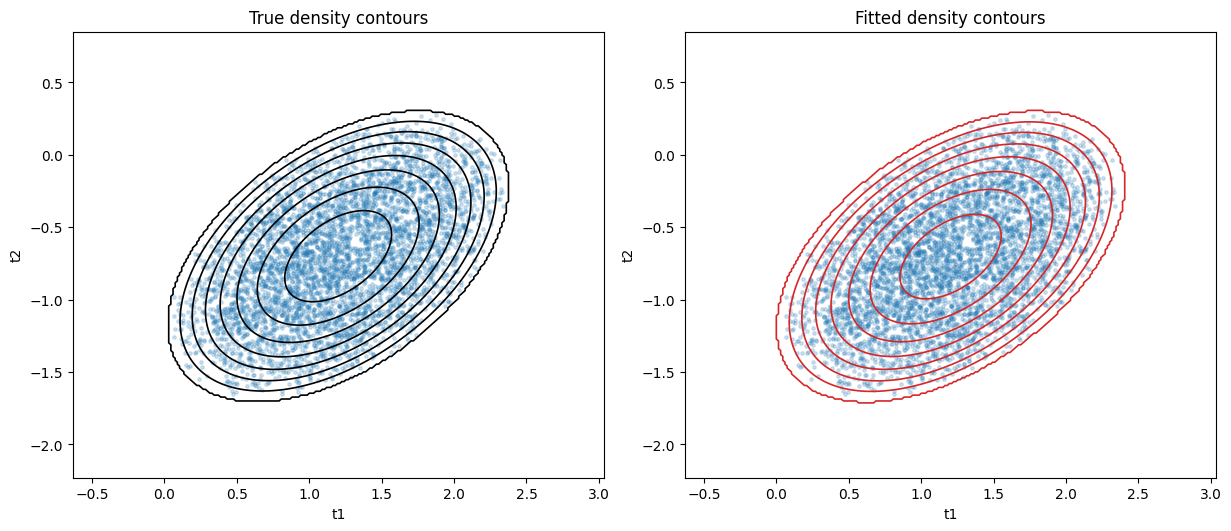

In [9]:
# Compare true vs fitted contours
zz_fit = density_bivariate_trunc_parabola(grid, mu_hat, Sigma_hat)

fig, ax = plt.subplots(1, 2, figsize=(12.2, 5.2), constrained_layout=True)

ax[0].scatter(samples[:, 0], samples[:, 1], s=6, alpha=0.2, color='tab:blue')
ax[0].contour(xx, yy, zz_true, levels=9, colors='black', linewidths=1.2)
ax[0].set_title('True density contours')
ax[0].set_xlabel('t1')
ax[0].set_ylabel('t2')
ax[0].axis('equal')

ax[1].scatter(samples[:, 0], samples[:, 1], s=6, alpha=0.2, color='tab:blue')
ax[1].contour(xx, yy, zz_fit, levels=9, colors='tab:red', linewidths=1.2)
ax[1].set_title('Fitted density contours')
ax[1].set_xlabel('t1')
ax[1].set_ylabel('t2')
ax[1].axis('equal')

plt.show()


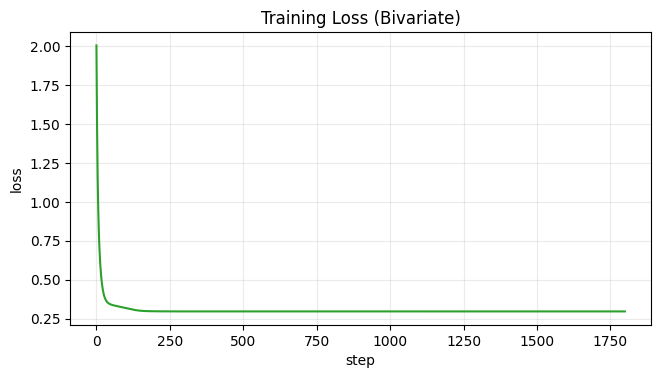

In [10]:
# Optimization trace
plt.figure(figsize=(7.5, 3.8))
plt.plot(history, color='tab:green')
plt.title('Training Loss (Bivariate)')
plt.xlabel('step')
plt.ylabel('loss')
plt.grid(alpha=0.25)
plt.show()
